# Calibration Visualization Dashboard

This notebook visualizes results from two calibration methods:
1. **Odometry-based Calibration** (Hand-Eye Calibration from sliding window)
2. **GICP-based Calibration** (Point Cloud Registration)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

## 1. Odometry-based Calibration (Hand-Eye)
Visualizes the extrinsic calibration computed from synchronized Lidar and Visual odometry.

In [3]:
# Load Time-Synced Calibration Results
odom_csv_path = '/home/ros/ros_ws/src/data/store_v1/time_synced.csv'

try:
    df_odom = pd.read_csv(odom_csv_path)
    print(f"Loaded {len(df_odom)} odometry calibration estimates")
    
    # Convert Quaternions to Euler Angles (Yaw, Pitch, Roll)
    quats = df_odom[['quat_x', 'quat_y', 'quat_z', 'quat_w']].values
    r = R.from_quat(quats)
    ypr = r.as_euler('zyx', degrees=True)
    
    df_odom['yaw'] = ypr[:, 0]
    df_odom['pitch'] = ypr[:, 1]
    df_odom['roll'] = ypr[:, 2]
    
    # Plot Translation
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle('Odometry Calibration: Translation over Time')
    
    axes[0].plot(df_odom['timestamp'], df_odom['trans_x'], 'r-', label='X')
    axes[0].set_ylabel('X (m)')
    axes[0].legend()
    
    axes[1].plot(df_odom['timestamp'], df_odom['trans_y'], 'g-', label='Y')
    axes[1].set_ylabel('Y (m)')
    axes[1].legend()
    
    axes[2].plot(df_odom['timestamp'], df_odom['trans_z'], 'b-', label='Z')
    axes[2].set_ylabel('Z (m)')
    axes[2].set_xlabel('Timestamp')
    axes[2].legend()
    plt.show()
    
    # Plot Rotation
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle('Odometry Calibration: Rotation over Time')
    
    axes[0].plot(df_odom['timestamp'], df_odom['yaw'], 'c-', label='Yaw')
    axes[0].set_ylabel('Yaw (deg)')
    axes[0].legend()
    
    axes[1].plot(df_odom['timestamp'], df_odom['pitch'], 'm-', label='Pitch')
    axes[1].set_ylabel('Pitch (deg)')
    axes[1].legend()
    
    axes[2].plot(df_odom['timestamp'], df_odom['roll'], 'y-', label='Roll')
    axes[2].set_ylabel('Roll (deg)')
    axes[2].set_xlabel('Timestamp')
    axes[2].legend()
    plt.show()
    
except FileNotFoundError:
    print(f"File not found: {odom_csv_path}")
except Exception as e:
    print(f"Error processing odometry data: {e}")

File not found: /home/ros/ros_ws/src/data/store_v1/time_synced.csv


## 2. GICP-based Calibration
Visualizes the extrinsic calibration computed from Point Cloud Registration (GICP).

Loaded 25 GICP calibration frames
Ground Truth (Camera -> Velodyne):
Translation: [ 0.27290343 -0.00196927 -0.0722859 ]
Rotation (YPR): [-63.02612503  89.04830978 -26.9353502 ]


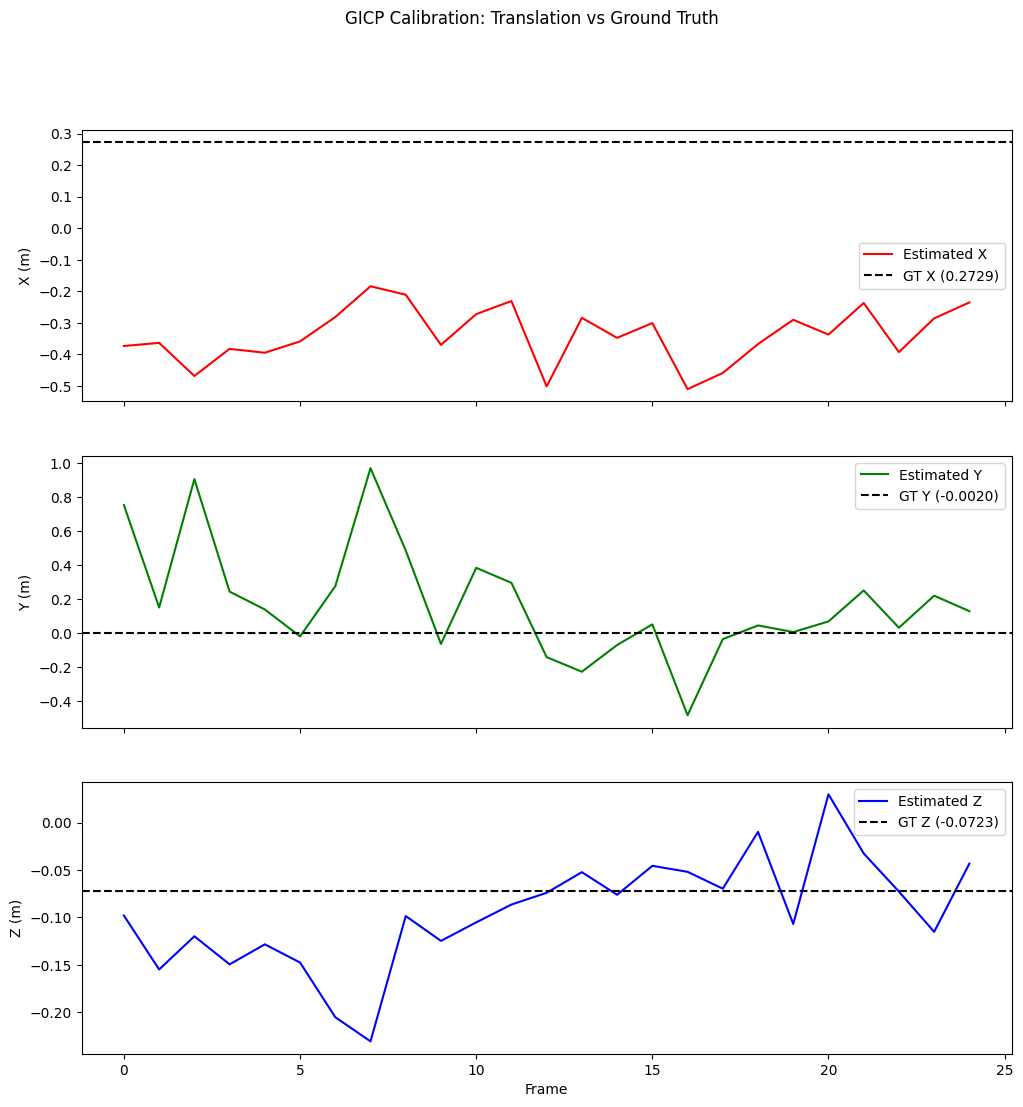

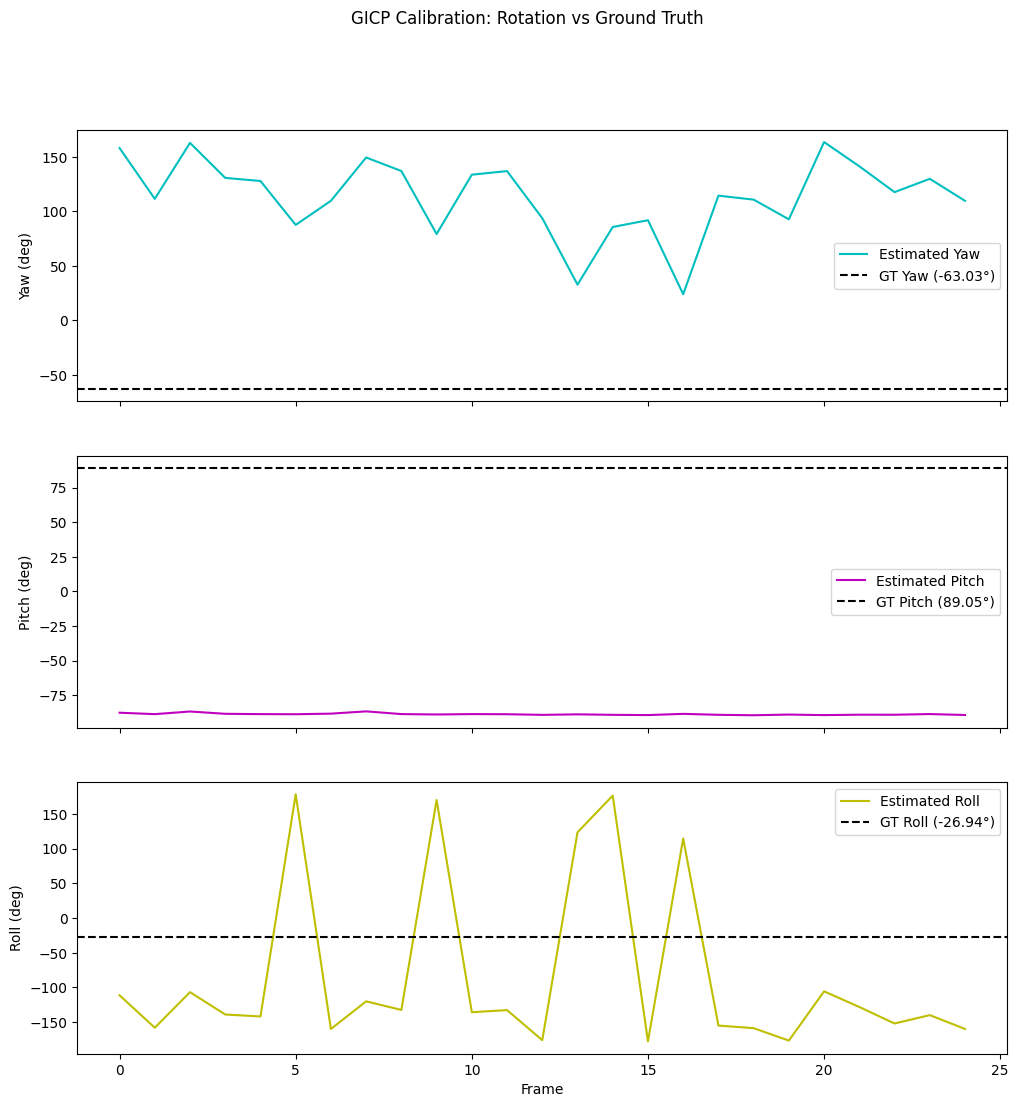

In [4]:
# Load GICP Calibration Results
gicp_csv_path = '/home/nail/other_work/Ro/CL_Calib/calib_ws/src/archive/rs_gicp_calibration_results_v1.csv'

try:
    df_gicp = pd.read_csv(gicp_csv_path)
    print(f"Loaded {len(df_gicp)} GICP calibration frames")
    
    # Ground Truth Calibration (Velodyne -> Camera)
    R_gt_matrix = np.array([
        [7.533745e-03, -9.999714e-01, -6.166020e-04],
        [1.480249e-02, 7.280733e-04, -9.998902e-01],
        [9.998621e-01, 7.523790e-03, 1.480755e-02]
    ])
    T_gt_vector = np.array([-4.069766e-03, -7.631618e-02, -2.717806e-01])

    # Convert to Camera -> Velodyne (Target Frame for GICP)
    T_cam_velo = np.eye(4)
    T_cam_velo[:3, :3] = R_gt_matrix
    T_cam_velo[:3, 3] = T_gt_vector
    T_velo_cam = np.linalg.inv(T_cam_velo)

    # Extract GT Translation and Rotation (YPR)
    gt_translation = T_velo_cam[:3, 3]
    gt_rotation = R.from_matrix(T_velo_cam[:3, :3])
    gt_ypr = gt_rotation.as_euler('zyx', degrees=True)

    print("Ground Truth (Camera -> Velodyne):")
    print(f"Translation: {gt_translation}")
    print(f"Rotation (YPR): {gt_ypr}")
    
    # Plot Translation
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    fig.suptitle('GICP Calibration: Translation vs Ground Truth')

    axes[0].plot(df_gicp['timestamp'], df_gicp['pos_x'], 'r-', label='Estimated X')
    axes[0].axhline(y=gt_translation[0], color='k', linestyle='--', label=f'GT X ({gt_translation[0]:.4f})')
    axes[0].set_ylabel('X (m)')
    axes[0].legend()

    axes[1].plot(df_gicp['timestamp'], df_gicp['pos_y'], 'g-', label='Estimated Y')
    axes[1].axhline(y=gt_translation[1], color='k', linestyle='--', label=f'GT Y ({gt_translation[1]:.4f})')
    axes[1].set_ylabel('Y (m)')
    axes[1].legend()

    axes[2].plot(df_gicp['timestamp'], df_gicp['pos_z'], 'b-', label='Estimated Z')
    axes[2].axhline(y=gt_translation[2], color='k', linestyle='--', label=f'GT Z ({gt_translation[2]:.4f})')
    axes[2].set_ylabel('Z (m)')
    axes[2].set_xlabel('Frame')
    axes[2].legend()
    plt.show()

    # Plot Rotation
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    fig.suptitle('GICP Calibration: Rotation vs Ground Truth')

    axes[0].plot(df_gicp['timestamp'], df_gicp['yaw'], 'c-', label='Estimated Yaw')
    axes[0].axhline(y=gt_ypr[0], color='k', linestyle='--', label=f'GT Yaw ({gt_ypr[0]:.2f}°)')
    axes[0].set_ylabel('Yaw (deg)')
    axes[0].legend()

    axes[1].plot(df_gicp['timestamp'], df_gicp['pitch'], 'm-', label='Estimated Pitch')
    axes[1].axhline(y=gt_ypr[1], color='k', linestyle='--', label=f'GT Pitch ({gt_ypr[1]:.2f}°)')
    axes[1].set_ylabel('Pitch (deg)')
    axes[1].legend()

    axes[2].plot(df_gicp['timestamp'], df_gicp['roll'], 'y-', label='Estimated Roll')
    axes[2].axhline(y=gt_ypr[2], color='k', linestyle='--', label=f'GT Roll ({gt_ypr[2]:.2f}°)')
    axes[2].set_ylabel('Roll (deg)')
    axes[2].set_xlabel('Frame')
    axes[2].legend()
    plt.show()

except FileNotFoundError:
    print(f"File not found: {gicp_csv_path}")
except Exception as e:
    print(f"Error processing GICP data: {e}")